Window size 208 is selected for 1th rank
Window size 208 is selected for 2th rank
Evaluation Result:  {'AUC-PR': 0.07843151366104176, 'AUC-ROC': 0.5018503447450807, 'VUS-PR': 0.03195474493464413, 'VUS-ROC': 0.5514698448372005, 'Standard-F1': 0.07542579075425791, 'PA-F1': 0.5637766681797549, 'Event-based-F1': 0.11428571428571417, 'R-based-F1': 0.015887863303061547, 'Affiliation-F': 0.7237550557812513}


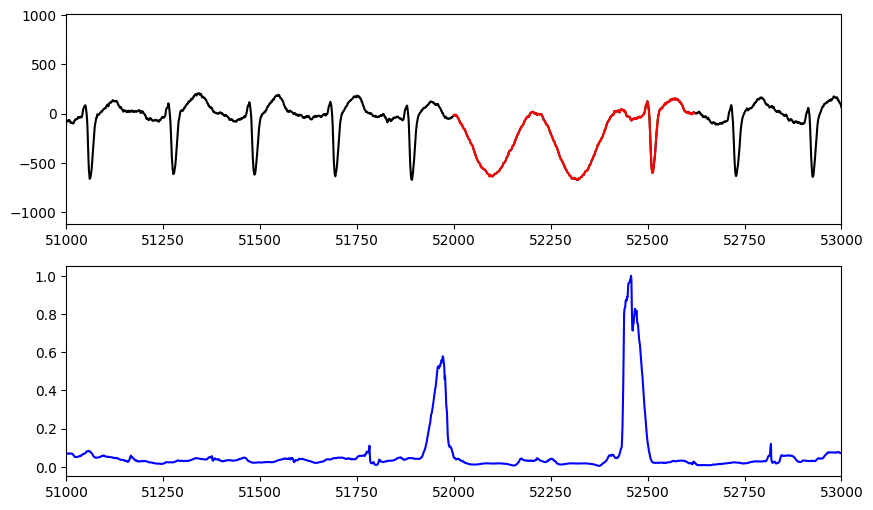

In [3]:
import pandas as pd
from TSB_AD.model_wrapper import run_Unsupervise_AD, run_Semisupervise_AD
from TSB_AD.evaluation.metrics import get_metrics
from TSB_AD.utils.dataAccess import *
from TSB_AD.utils.utility import postprocess_scores
from TSB_AD.HP_list import Optimal_Uni_algo_HP_dict
from TSB_AD.utils.slidingWindows import find_length_rank
import matplotlib.pyplot as plt
import numpy as np


Unsupervise_AD_Pool = ['SR', 'NORMA', 'Series2Graph', 'Sub_IForest', 'IForest', 'LOF', 'Sub_LOF', 'POLY', 'MatrixProfile', 'Sub_PCA', 'PCA', 'HBOS', 
                        'Sub_HBOS', 'KNN', 'Sub_KNN','KMeansAD', 'KMeansAD_U', 'KShapeAD', 'COPOD', 'CBLOF', 'COF', 'EIF', 'RobustPCA', 'Lag_Llama', 'TimesFM', 'Chronos', 'MOMENT_ZS']
Semisupervise_AD_Pool = ['SAND', 'MCD', 'Sub_MCD', 'OCSVM', 'Sub_OCSVM', 'AutoEncoder', 'CNN', 'LSTMAD', 'TranAD', 'USAD', 'OmniAnomaly', 
                        'AnomalyTransformer', 'TimesNet', 'FITS', 'Donut', 'OFA', 'MOMENT_FT']

# Specify Anomaly Detector to use and data directory
AD_Name = 'Sub_LOF'   
Optimal_Det_HP = Optimal_Uni_algo_HP_dict[AD_Name]

# Loading Data
# data_direc = 'Datasets/TSB-AD-U/001_NAB_id_1_Facility_tr_1007_1st_2014.csv'
data_direc = 'Datasets/MyData/labeled_ucr/001_UCR_Anomaly_DISTORTED1sddb40tr_35000_1st_52000.csv'
df = pd.read_csv(data_direc).dropna()
data = df.iloc[:, 0:-1].values.astype(float) # 所有行，不包括最后一列（label）
label = df['Label'].astype(int).to_numpy()
train_index = data_direc.split('.')[0].split('_')[-3]
data_train = data[:int(train_index), :]

# hyperparameters
slidingWindow = find_length_rank(data, rank=1)

# Applying Anomaly Detector, 这里会输出分数和打标
if AD_Name in Semisupervise_AD_Pool:
    output = run_Semisupervise_AD(AD_Name, data_train, data, **Optimal_Det_HP)
elif AD_Name in Unsupervise_AD_Pool:
    output = run_Unsupervise_AD(AD_Name, data, **Optimal_Det_HP)
else:
    raise Exception(f"{AD_Name} is not defined")

# if slidingWindow > 1:
#     output = postprocess_scores(slidingWindow, output)

# if output not a np Array, then it is not available in TSB-AD
if isinstance(output, np.ndarray):
    output_label = np.zeros(len(output))
    threshold = np.mean(output) + 5*np.std(output)
    for i in range(len(output)):
        if output[i] > threshold:
            output_label[i] = 1

    # Evaluation 这里是算评价指标，对比label
    evaluation_result = get_metrics(output, label, slidingWindow=slidingWindow, pred=output > (np.mean(output)+3*np.std(output)))
    print('Evaluation Result: ', evaluation_result)

    prefix, test_loc, ab_l = parseDataFile(data_direc)
    plotRange= (ab_l-1000, ab_l+1000)

    range_anomaly = range_convers_new(label)
    range_predict_anomaly = range_convers_new(output_label)

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    ax[0].plot(data, 'k')
    # ax[1].plot(data, 'k')

    for r in range_anomaly:
        if r[0]==r[1]:
            ax[0].plot(r[0],data[r[0]],'r.')
        else:
            ax[0].plot(range(r[0],r[1]+1),data[range(r[0],r[1]+1)],'r')
            
    # for r in range_predict_anomaly:
    #     if r[0]==r[1]:
    #         ax[1].plot(r[0],data[r[0]],'r.', size=20)
    #     else:
    #         ax[1].plot(range(r[0],r[1]+1),data[range(r[0],r[1]+1)],'r', size=20)
    
    ax[1].plot(output, 'b')
            
    # xlim 
    ax[0].set_xlim(plotRange)
    ax[1].set_xlim(plotRange)
else:
    print('Anomaly Detector is not available in TSB-AD')
    print('Output:', output)